# =============================================================

#  Predict Telco Customer Churn with Spark Machine Learning & Magellan

# =============================================================

What is Magellan ?
- Magellan is a flexible, AI-powered Analytics platform that combines open source ML with advanced analytics, enterprise-grade BI, and capabilities to acquire, merge, manage and analyze Big Data and Big Content stored in your Enterprise Information Management (EIM) systems. Magellan enables machine-assisted decision making, automation, and business optimization.


What is Spark Machine Learning ?

- Apache Spark’s machine learning library makes practical machine learning scalable and easy. The library consists of common machine learning algorithms and utilities, including classification, regression, clustering, collaborative filtering, dimensionality reduction, lower-level optimization primitives, and higher-level pipeline APIs.

# =============================================================

What is this Notebook about?
- In this magellan notebook, you will use Apache Spark and the Spark machine learning library to build a Customer Churn Prediction model.

- Customer Churn refers to when a customer ceases to complete target actions (e.g. add to cart, leave a comment, etc.) within a given period of time OR when a customer ceases his or her relationship with a company. 
- Thus, predicting “likely-to-churn” from engaged customers will allow us to:

    1. Analyze the reasons for such behavior 
    2. Refocus and personalize offerings for different groups of churning customers
    3. Proactivley target likely to churn customers with customized offerings
 
What kind of data are we working with?
- Customers who left within the last month – the column is called Churn
- Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
- Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
- Demographic info about customers – gender, age range, and if they have partners and dependents

What are the Notebook Requirements?

- historical_data (Historical data containing information about telco customers)
- Magellan - Pyspark Kernel
- Magellan Version 16.6

# =============================================================

# In this notebook, you will learn how to:

1. Load data from the Magellan Data Lake (HDFS)
2. Conduct initial data exploration & Impute Missing Data
3. Data Processing & Variable Selection
4. Create & Train A Decision Tree Model Pipeline
5. Make Predictions On Test Data and Evaluate Model Accuracy
6. Save & deploy the machine learning pipeline to empower users
6. Explore and visualize the prediction results

# =============================================================

# 1. Load data from the Magellan Data Lake (HDFS)

In [27]:
# import visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# load the historical customer data
customers_data = spark.sql("select gender, seniorcitizen, partner, dependents, tenure, phoneservice,\
                           multiplelines, internetservice, onlinesecurity, onlinebackup, deviceprotection, techsupport,\
                           streamingtv,streamingmovies, contract, paperlessbilling, paymentmethod, monthlycharges,\
                           totalcharges, churn from telecom_churn.historical_data")


# 2. Conduct Initial Data Exploration & Impute Missing Data



- Count number of records
- Check distribution of target label
- Check values of a few records in the data
- Check Missing Values in each column and Remove

In [28]:
print "There are ", format(customers_data.count(),',d'), "customer records"

There are  7,043 customer records


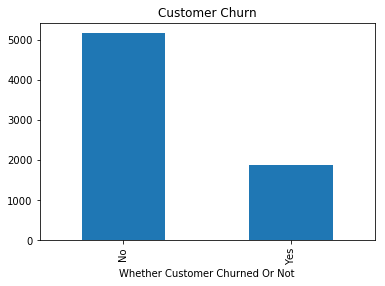

In [36]:
# Check distribution of target label - churn
data = customers_data.toPandas()
data['churn'].value_counts().plot(kind = 'bar')
plt.xlabel('Whether Customer Churned Or Not')
plt.title('Customer Churn')
plt.show()

## Let's see values of a few records


In [22]:
data.sample(5).transpose()

,4502,2593,7023,488,3395
gender,Male,Male,Male,Male,Male
seniorcitizen,0,1,1,0,0
partner,No,No,No,No,Yes
dependents,No,No,No,Yes,No
tenure,10,16,9,23,72
phoneservice,Yes,Yes,Yes,Yes,Yes
multiplelines,Yes,Yes,Yes,No,Yes
internetservice,Fiber optic,Fiber optic,Fiber optic,DSL,Fiber optic
onlinesecurity,No,No,No,No,No
onlinebackup,No,No,No,Yes,Yes


## What is the % of missing values in each column?


In [24]:
((data.isnull().sum()/data.shape[0])*100).round(decimals=2)

gender              0.16
seniorcitizen       0.16
partner             0.16
dependents          0.16
tenure              0.16
phoneservice        0.16
multiplelines       0.16
internetservice     0.16
onlinesecurity      0.16
onlinebackup        0.16
deviceprotection    0.16
techsupport         0.16
streamingtv         0.16
streamingmovies     0.16
contract            0.16
paperlessbilling    0.16
paymentmethod       0.16
monthlycharges      0.16
totalcharges        0.16
churn               0.16
dtype: float64

In [35]:
# Remove missing data
customers_data = customers_data.na.drop()
print "Since only 0.16 % of data is missing - we will remove that. There are now only", format(customers_data.count(),',d'), "customer records"

Since only 0.16 % of data is missing - we will remove that. There are now only 7,032 customer records


# ============================================================

# 3. Data Processing & Variable Selection (Model Pipeline Setup)


As an example, here we are building a pipleine that predicts whether or not a customer will churn based on various demographic and product usage characteristics about the customer. 

## Stages in Customer Churn Model Pipeline:
1. We will organize data into required format so that a machine learning algorithm can learn a pattern relating to churn. 
2. We will specify the inputs for the Machine learning algorithm to train a model on
3. We will use decision tree algorithm to predict whether customer will churn or not (step 4)
4. We will initialize the pipeline with a training data set. The initialized pipeline is then saved as a model in the Magellan data lake and published to Data Discovery for deployment purposes (Step 4)

In [37]:
# Upload spark utility packages
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer,VectorAssembler, OneHotEncoder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import functools 
import operator

In [55]:
stages = [] # set up a list for stages in our Pipeline

# select categorical columns
categoricalColumns = ['gender','seniorcitizen','partner','dependents','phoneservice','multiplelines',
                      'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 
                      'streamingtv', 'streamingmovies', 'contract','paperlessbilling','paymentmethod']

# Category Indexing with StringIndexer
indexers = [StringIndexer(inputCol = column, outputCol = column+"_index") for column in categoricalColumns]

# Use OneHotEncoder to convert categorical variables into binary SparseVectors
encoders = [OneHotEncoder(inputCol = column+"_index", outputCol = column+"_dummy") for column in categoricalColumns]

numericColumns = ['monthlycharges', 'totalcharges']

# Convert label into label indices using the StringIndexer
labelIndexer = StringIndexer(inputCol="churn", outputCol="label")

In [56]:
# Append all relevant columns into 1 list
input_cols = []
for i in categoricalColumns:
      input_cols.append(i+"_dummy")
for i in numericColumns:
      input_cols.append(i)
        
# assemble all inputs using VectorAssembler - this is required format for applying an algoirthm in next step
assembler = VectorAssembler(inputCols= input_cols, outputCol="features")

# 4. Create & Train A Decision Tree Model Pipeline

- Create a training and test set
- Train ML model pipeline on Training Data


Why are Decision Tree Algorithms Advantageous?
- Decision trees generate classification and regression models which can be used for feature selection and sample prediction. The transparency of these models is a big advantage over black-box learners, because the models are easy to understand and interpret, and they can be readily extracted and implemented in any programming language (with nested if-else statements) for use in production environments. Furthermore, decision trees require almost no data preparation (ie normalization) and can handle both categorical and continuous data. To remedy over-fitting and improve prediction accuracy, decision trees can also be limited to a certain depth or complexity, or bundled into ensembles of trees (ie random forests).

How do decision trees learn a pattern?
- A decision tree is a predictive model which maps observations (features) about an item to conclusions about the item's label or class. The model is generated using a top-down approach, where the source dataset is split into subsets using a statistical measure, often in the form of the Gini index or information gain via Shannon entropy. This process is applied recursively until a subset contains only samples with the same target class, or is halted by a predefined stopping criteria.

## Create a training and test set


In [52]:
(trainingData, testData) = customers_data.randomSplit([0.7, 0.3], seed = 123)
print(trainingData.count())
print(testData.count())

4902
2130


## Train ML model pipeline on Training Data

In [70]:
# Initialize a Decision Tree Classifier
decisionTree = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth=3)

# join all pipeline stages together
stages = functools.reduce(operator.concat, [indexers, encoders])
stages.append(labelIndexer)
stages.append(assembler)
stages.append(decisionTree)

pipeline = Pipeline(stages=stages)

final_pipeline = pipeline.fit(trainingData)

# 5. Make Predictions On Test Data and Evaluate Model Accuracy

- Now, we will test the above trained machine learning model on a sample test dataset that was not included in creating a machine learning model. This allows us to validate how well the model will perform in the real world. In order to validate performance, we will a measure called AUC - ROC
- AUC - ROC curve is a performance measurement for classification problem at various thresholds settings. It tells us how well the model is capable of distinguishing between classes - meaning customer will churn or will not churn. Higher the AUC (highest is 1), better the model is at predicting customers who will churn as churn and those wont churn as wont churn.

In [72]:
# Make predictions on test data
predictions = final_pipeline.transform(testData)

In [73]:
# Select actual values Vs model's prediction values in test data 
predictionAndLabels = predictions.select("label", "prediction")

In [74]:
# calculate auc - roc metric on test dataset
metrics = BinaryClassificationMetrics(predictionAndLabels.rdd)
print("Area under ROC = %s" % metrics.areaUnderROC)

Area under ROC = 0.755934247271


In [67]:
predictions.createOrReplaceTempView("predictions")

In [83]:
# create a confusion matrix to compare actual Vs Predicted label values in test data
confusion_matrix = spark.sql ("select count(*) as Customer_Count, label as Actual_Churn, prediction as Predicted_Churn from predictions group by label, prediction ")
confusion_matrix.show()

+--------------+------------+---------------+
|Customer_Count|Actual_Churn|Predicted_Churn|
+--------------+------------+---------------+
|           286|         1.0|            1.0|
|           133|         0.0|            1.0|
|           299|         1.0|            0.0|
|          1412|         0.0|            0.0|
+--------------+------------+---------------+



# 6. Save ML Pipeline & deploy to Magellan Data Discovery to empower users
- Save the ML model pipeline to magellan datalake


In [77]:
# save the pipeline to Magellan Datalake
final_pipeline.write().overwrite().save("hdfs://10.18.50.224/OpenText/models/Telco_Customer_Churn")

Click on Publish to Magellan Data Discovery and complete form as below:

1. User: Type your Data Discovery username: username@magellan
2. Password: Type your Data Discovery password
3. Repository: Select Spark Gateway
4. Name: type "Telco Customer Churn Model"
5. Description: "Leverage machine learning to predict which customers are likely to churn / switch to another provider, based on account information and usage history"
6. The model path uses the format hdfs://ambari/OpenText/models/, without the final slash. Replace the name ambari with the hostname of your server running the Ambari dashboard. For example in this scenario, we are using: hdfs://10.18.50.224/OpenText/models/Telco_Customer_Churn
8. Category: Select Categorical Classifier
9. Label: churn (Target or Outcome column)
10. Degradation Warning - Set as needed, for now we can keep it at 10 %
11. Schema Definition (inputs): In Dataframe variable, type trainingData, and choose Obtain. Magellan will automaticlly detect relevant columns / fields used to build the ML pipeline. Make sure to remove column "churn" (since that is the outcome of the model).
12. Set the security to Share with work group (as needed), and choose Publish.
13. Close the window if it says your model was published.

- Your machine learning pipeline is now available for users in Magellan Data Discovery when they are connected to the Spark repository
- Note: In order to score new data with the above created ML Model in Data Discovery, it requires same inputs (sample data provided = "Telco_churn_sample")

# Done!

# =============================================================

# * Additional: Explore and visualize the prediction results


In [84]:
# select columns from data
predicted_data = predictions.select('monthlycharges','prediction')

In [85]:
# convert to pandas
predicted_df = predicted_data.toPandas() 

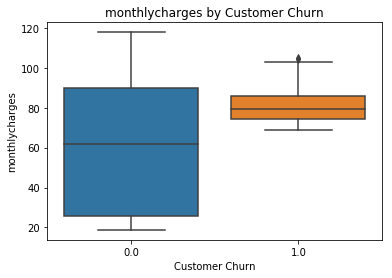

In [86]:
# visualize churn by monthlycharges
sns.boxplot(x="prediction", y="monthlycharges", data=predicted_df).set_title('monthlycharges by Customer Churn')
plt.xlabel("Customer Churn")
plt.ylabel("monthlycharges")
plt.show()

# =============================================================

# Author

Arjun Arora is a Data Scientist at Opentext. He specializes in technology evangelism, data science training, demos, and proof of concepts, that leverage Opentext Magellan and Big Data technologies, such as, Apache Hadoop and Apache Spark. 

For questions, please reach out to arjuna@opentext.com

Date: 1/28/2020